<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.metrics import f1_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим набор данных на пропуски

In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Проверим набор данных на наличие явных дубликатов

In [7]:
data.duplicated().sum()

0

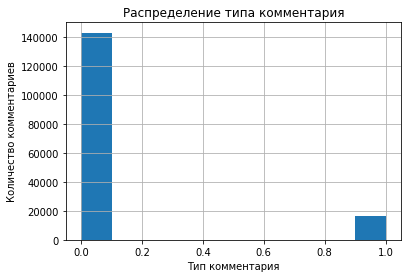

In [8]:
data['toxic'].hist()
plt.xlabel('Тип комментария')
plt.ylabel('Количество комментариев')
plt.title('Распределение типа комментария')
plt.show();

**Вывод:** Исходный набор данных содержит 159292 записей. Явные дубликаты и пропуски отсутсвуют. Количество нетоксичных комментариев превосходит количество токсичных примерно в 7 раз. 

Подготовим данные к дальнейшему построению моделей машинного обучения:

1. Загрузим список стоп-слов

In [9]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Лемматизируем комментарии

In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
def lemmatize(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stopwords]
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
    text = ' '.join(text)
    return text

In [15]:
data['lemmatized'] = data['text'].apply(lemmatize)

In [19]:
data.head()

,text,toxic,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


## Обучение

Разобьем данные на выборки

In [20]:
state = np.random.RandomState(12345)

In [21]:
features = data.drop(columns=['toxic'])
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify = target)

In [22]:
print(features_train.shape, target_train.shape)

(127433, 2) (127433,)


In [23]:
print(features_test.shape, target_test.shape)

(31859, 2) (31859,)


Построим пайплайн обучения

In [24]:
def train(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, n_jobs =-1, verbose=0, scoring='f1')
    grid_search.fit(features_train['lemmatized'], target_train)
    print('Наилучшая мера f1:', grid_search.best_score_)
    print('Наилучшие параметры:', grid_search.best_params_)
    return grid_search


Построим модель логистической регрессии

In [25]:
model_lr = train(LogisticRegression(), {"model__penalty" : ['l2'], "model__class_weight" : ['None', 'balanced'], "model__C" : [0.1, 1, 10]})

Наилучшая мера f1: 0.7746190204185761
Наилучшие параметры: {'model__C': 10, 'model__class_weight': 'None', 'model__penalty': 'l2'}


Построим модель случайного леса 

In [26]:
model_rf = train(RandomForestClassifier(), {'model__criterion':['gini','entropy'], "model__n_estimators" : [30, 40, 50, 60], "model__max_depth" : [6, 8, 10, 12]})

Наилучшая мера f1: 0.0
Наилучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6, 'model__n_estimators': 30}


Построим модель CatBoost

In [27]:
model_cat = train(CatBoostClassifier(logging_level='Silent'), {"model__iterations" : [10, 60], "model__learning_rate" : [0.01, 0.02, 0.03], "model__depth" : [1, 6]})

Наилучшая мера f1: 0.5326295547673792
Наилучшие параметры: {'model__depth': 6, 'model__iterations': 60, 'model__learning_rate': 0.03}


**Вывод:** наилучшей оказалась модель  логистической регрессии, для нее значение метрики F1 равно 0.77. Протестируем данную модель на тестовой выборке.

In [28]:
predictions_lr = model_lr.predict(features_test['lemmatized'])
print('Значение метрики F1 на тестовой выборке для модели логистической регресии:', f1_score(target_test, predictions_lr))

Значение метрики F1 на тестовой выборке для модели логистической регресии: 0.7797537619699042


## Выводы

В ходе работы познакомились с набором данных, который содержит 159292 комментария. Лемматизировали данные комментарии, посмотрели на колиечство токсичных и нетоксичных комментариев. Построили различные модели машинного обучения с различными гиперпараметрами: логистическую регрессию, случайный лес и CatBoost. Наилучшей оказалась модель логистической регрессии, значение меры f1 на тестовой выборке для которой равно 0.78.